<a href="https://colab.research.google.com/github/casjunior93/projeto-integrador-iv/blob/main/Etl_e_cria%C3%A7%C3%A3o_de_Modelos_com_Arima.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bibliotecas fundamentais

In [212]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import scipy.stats as stats
import urllib.request, json 
from pandas.io.json import json_normalize

#Scikit-Learn
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from lightgbm import LGBMRegressor

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import cross_val_score, train_test_split

from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

#Configura o pandas para não exibir resultados em notação científica
pd.options.display.float_format = '{:.2f}'.format

#Semente aleatória do Numpy
np.random.seed(42)

#Data local
import locale
# Colab não suporta
#locale.setlocale(locale.LC_ALL, 'pt_BR.utf8')

# URL base da api de dados

In [213]:
url_base = 'https://univesp-analytics.vercel.app/api/get'

# Lendo Json com Pandas

In [214]:
%%time
pagina = 1
limite = 10000
fim_iteracao_api = False
df_dados_api_original = pd.DataFrame([])

print(f'Início das requisições')
while fim_iteracao_api == False:
  with urllib.request.urlopen(url_base + '?page=' + str(pagina) + '&limite=' + str(limite)) as url:
    data = json.loads(url.read().decode())
    df = pd.DataFrame(json_normalize(data))
    print('.', end='')
    if len(data) == 0:
      print('')
      print(f'Fim. Total de {pagina - 1} páginas e {df_dados_api_original.shape[0]} registros.')
      fim_iteracao_api = True
    else:
      if pagina % 100 == 0:
        print(f'Fim leitura página {pagina}')
      pagina += 1
      df_dados_api_original = pd.concat([df_dados_api_original, df], ignore_index = True)

Início das requisições
..........
Fim. Total de 9 páginas e 83431 registros.
CPU times: user 1.66 s, sys: 51.8 ms, total: 1.71 s
Wall time: 18.5 s


In [215]:
%%time
''' with urllib.request.urlopen(url_base + '?page=' + str(pagina) + '&limite=' + str(limite)) as url:
    data = json.loads(url.read().decode())
    df_dados_api_original = pd.DataFrame(json_normalize(data)) '''

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 9.06 µs


" with urllib.request.urlopen(url_base + '?page=' + str(pagina) + '&limite=' + str(limite)) as url:\n    data = json.loads(url.read().decode())\n    df_dados_api_original = pd.DataFrame(json_normalize(data)) "

Cópia dos dados da api

In [216]:
df_dados_api = df_dados_api_original.copy()

Dimensão dos dados - Linhas, colunas

In [217]:
df_dados_api.shape

(83431, 9)

# Visualizando dados originais

Mudando ordenação dos dados

In [218]:
df_dados_api.sort_index(ascending=False, inplace=True, ignore_index=True)

Cinco primeiros registros do dataframe - Em ordem da disposição na API

In [219]:
df_dados_api.head()

,_id,temp_ar,umid_ar,type,local,time.time_js,time.data,time.hora,teste
0,63fea0720dd58484fc266c80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,123.00
1,63ffdbb91a4eb0dfdd6a11a7,2,3,teste,NaN,2023-03-01T23:11:53.036Z,01/03/2023,20:11:53,NaN
2,63ffdbde1a4eb0dfdd6a11a8,10,10,teste,NaN,2023-03-01T23:12:30.063Z,01/03/2023,20:12:30,NaN
3,63ffdea6722bef68acc5bb72,333,333,teste,NaN,2023-03-01T23:24:21.438Z,01/03/2023,23:24:21,NaN
4,63ffed2b38c8784e07b788f2,15,15,teste,NaN,01/03/2023 21:26:19,01/03/2023,21:26:19,NaN


Cinco últimos registros do dataframe

In [220]:
df_dados_api.tail()

,_id,temp_ar,umid_ar,type,local,time.time_js,time.data,time.hora,teste
83426,64566da63e480bbd05dd5b8d,25.40,54.60,teste,comAr,"06/05/2023, 12:09:26","06/05/2023,",12:09:26,NaN
83427,64566ebb3e480bbd05dd5b8e,24.20,63.60,teste,semAr,"06/05/2023, 12:14:03","06/05/2023,",12:14:03,NaN
83428,64566ed43e480bbd05dd5b8f,25.40,54.50,teste,comAr,"06/05/2023, 12:14:28","06/05/2023,",12:14:28,NaN
83429,64566fe93e480bbd05dd5b90,24.30,63.50,teste,semAr,"06/05/2023, 12:19:05","06/05/2023,",12:19:05,NaN
83430,645670023e480bbd05dd5b91,25.40,54.60,teste,comAr,"06/05/2023, 12:19:30","06/05/2023,",12:19:30,NaN


Verificando dados nulos

In [221]:
df_dados_api.isnull().sum()

_id                 0
temp_ar             3
umid_ar             3
type                1
local           55412
time.time_js        1
time.data           1
time.hora           1
teste           83430
dtype: int64

Excluindo colunas desnecessárias

In [222]:
del df_dados_api['teste']
del df_dados_api['_id']
del df_dados_api['type']
del df_dados_api['time.time_js']
df_dados_api.head()

,temp_ar,umid_ar,local,time.data,time.hora
0,NaN,NaN,NaN,NaN,NaN
1,2,3,NaN,01/03/2023,20:11:53
2,10,10,NaN,01/03/2023,20:12:30
3,333,333,NaN,01/03/2023,23:24:21
4,15,15,NaN,01/03/2023,21:26:19


Tratando nova coluna local

In [223]:
df_dados_api.local.value_counts()

semAr    22557
comAr     5458
API          2
teste        1
123          1
Name: local, dtype: int64

In [224]:
values = {"local": "comAr"}
df_dados_api.fillna(value=values, inplace=True)

In [225]:
df_dados_api.local.value_counts()

comAr    60870
semAr    22557
API          2
teste        1
123          1
Name: local, dtype: int64

Limpeza de dados nulos

In [226]:
df_dados_api.dropna(inplace = True)
df_dados_api.isnull().sum()

temp_ar      0
umid_ar      0
local        0
time.data    0
time.hora    0
dtype: int64

Removendo dados duplicados

In [227]:
df_dados_api.shape

(83428, 5)

In [228]:
df_dados_api.drop_duplicates(inplace=True, ignore_index=True)
df_dados_api.shape

(83428, 5)

# Comportamento das variáveis

Tipo dos dados e convertendo strings para float

In [229]:
df_dados_api.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83428 entries, 0 to 83427
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   temp_ar    83428 non-null  object
 1   umid_ar    83428 non-null  object
 2   local      83428 non-null  object
 3   time.data  83428 non-null  object
 4   time.hora  83428 non-null  object
dtypes: object(5)
memory usage: 3.2+ MB


In [230]:
df_dados_api = df_dados_api.astype({'temp_ar':'float', 'umid_ar':'float'})
df_dados_api.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83428 entries, 0 to 83427
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   temp_ar    83428 non-null  float64
 1   umid_ar    83428 non-null  float64
 2   local      83428 non-null  object 
 3   time.data  83428 non-null  object 
 4   time.hora  83428 non-null  object 
dtypes: float64(2), object(3)
memory usage: 3.2+ MB


Análise descritiva dos dados

In [231]:
df_dados_api.describe()

,temp_ar,umid_ar
count,83428.00,83428.00
mean,25.60,59.69
std,2.60,8.36
min,2.00,3.00
25%,25.00,54.00
50%,26.00,58.00
75%,26.50,64.10
max,333.00,333.00


Opa, parece haver outliers.

Separando os conjuntos de dados do ambiente com ar condicionado e sem ar condicionado.

In [232]:
df_comAr = df_dados_api.loc[df_dados_api['local'] == 'comAr']
df_semAr = df_dados_api.loc[df_dados_api['local'] == 'semAr']

Verificando outliers

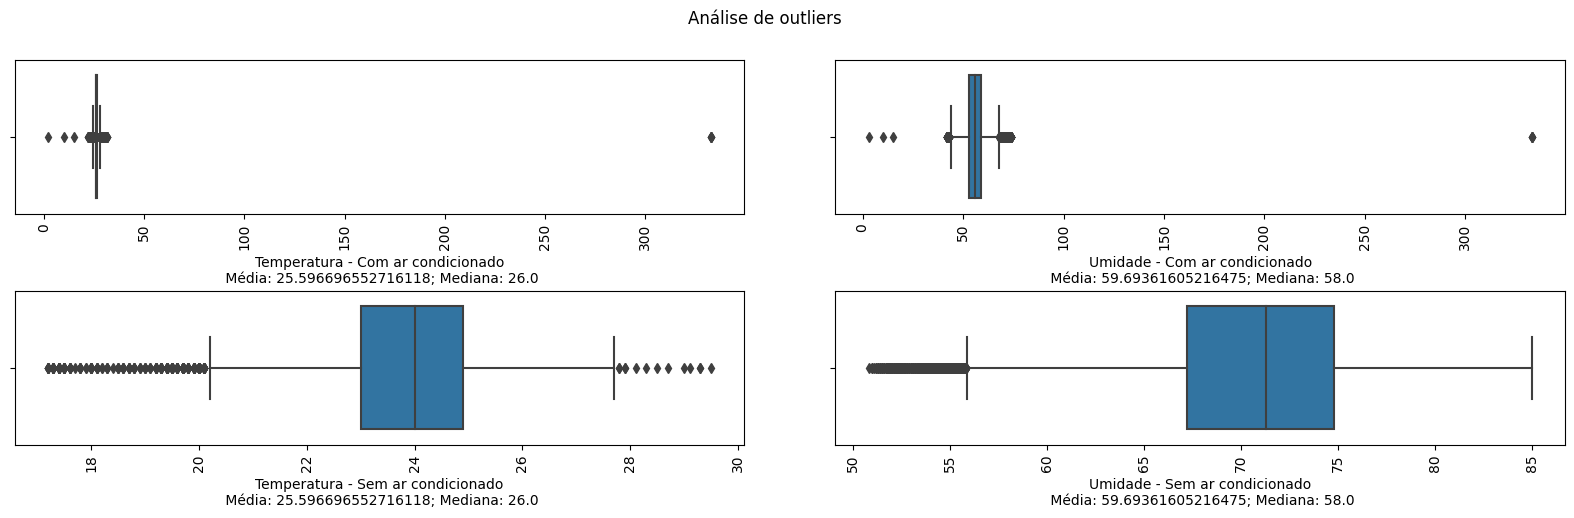

CPU times: user 577 ms, sys: 107 ms, total: 684 ms
Wall time: 720 ms


In [233]:
%%time
fig, axes = plt.subplots(2, 2, figsize = (20,5))
fig.subplots_adjust(hspace=0.5, wspace=0.125)
fig.suptitle('Análise de outliers')

#Temperatura Com ar condicionado - Boxplot
sns.boxplot(ax=axes[0,0],x=df_comAr['temp_ar'])
axes[0,0].tick_params(axis='x', rotation=90)
axes[0,0].set(xlabel='Temperatura - Com ar condicionado\n Média: ' + str(df_dados_api['temp_ar'].mean()) + '; Mediana: ' + str(df_dados_api['temp_ar'].median()))

#Umidade Com ar condicionado - Boxplot
sns.boxplot(ax=axes[0,1],x=df_comAr['umid_ar'])
axes[0,1].tick_params(axis='x', rotation=90)
axes[0,1].set(xlabel='Umidade - Com ar condicionado\n Média: ' + str(df_dados_api['umid_ar'].mean()) + '; Mediana: ' + str(df_dados_api['umid_ar'].median()))

#Temperatura Com ar condicionado - Boxplot
sns.boxplot(ax=axes[1,0],x=df_semAr['temp_ar'])
axes[1,0].tick_params(axis='x', rotation=90)
axes[1,0].set(xlabel='Temperatura - Sem ar condicionado\n Média: ' + str(df_dados_api['temp_ar'].mean()) + '; Mediana: ' + str(df_dados_api['temp_ar'].median()))

#Umidade Com ar condicionado - Boxplot
sns.boxplot(ax=axes[1,1],x=df_semAr['umid_ar'])
axes[1,1].tick_params(axis='x', rotation=90)
axes[1,1].set(xlabel='Umidade - Sem ar condicionado\n Média: ' + str(df_dados_api['umid_ar'].mean()) + '; Mediana: ' + str(df_dados_api['umid_ar'].median()))

plt.show();

Excluindo outliers superiores do conjunto com ar condicionado

In [234]:
def limites_outliers(coluna):
  Q1 = coluna.quantile(.25)
  Q3 = coluna.quantile(.75)
  IIQ = Q3 - Q1
  limite_inferior = Q1 - 1.5 * IIQ
  limite_superior = Q3 + 1.5 * IIQ
  return limite_inferior, limite_superior

In [235]:
limite_inferior_temp_ar, limite_superior_temp_ar = limites_outliers(df_comAr['temp_ar'])
limite_inferior_umid_ar, limite_superior_umid_ar = limites_outliers(df_comAr['umid_ar'])

Visualizando registros considerados como outliers

In [236]:
selecao_temp_ar = (df_comAr['temp_ar'] > limite_superior_temp_ar) | (df_comAr['umid_ar'] > limite_superior_umid_ar)
temp_ar1 = df_comAr[selecao_temp_ar]
temp_ar1.describe()

,temp_ar,umid_ar
count,1983.00,1983.00
mean,28.23,54.83
std,13.80,15.32
min,21.90,43.00
25%,28.10,48.00
50%,28.20,51.00
75%,28.40,55.00
max,333.00,333.00


In [237]:
selecao_temp_ar2 = (temp_ar1['temp_ar'] < 333.0) | (temp_ar1['umid_ar'] < 333.0)
temp_ar2 = temp_ar1[selecao_temp_ar2]
temp_ar2.describe()

,temp_ar,umid_ar
count,1979.00,1979.00
mean,27.61,54.27
std,1.60,8.86
min,21.90,43.00
25%,28.10,48.00
50%,28.20,51.00
75%,28.40,55.00
max,31.20,74.00


Removendo dados com valor de temp_ar e umid_ar iguais à 333,0. Não vou remover valores menores que este porque são valores possíveis de acontecer.

In [238]:
selecao_temp_ar = (df_comAr['temp_ar'] <= 31.20) & (df_comAr['umid_ar'] <= 74)
df_comAr = df_comAr[selecao_temp_ar]

Revendo boxplots

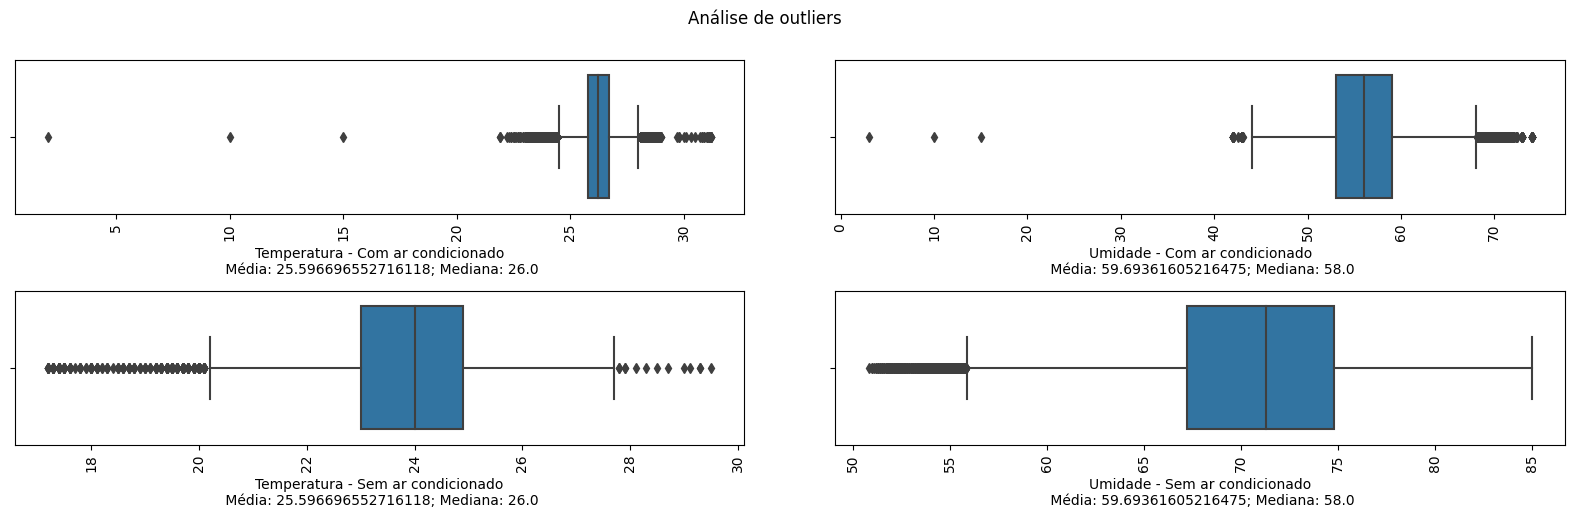

In [239]:
fig, axes = plt.subplots(2, 2, figsize = (20,5))
fig.subplots_adjust(hspace=0.5, wspace=0.125)
fig.suptitle('Análise de outliers')

#Temperatura Com ar condicionado - Boxplot
sns.boxplot(ax=axes[0,0],x=df_comAr['temp_ar'])
axes[0,0].tick_params(axis='x', rotation=90)
axes[0,0].set(xlabel='Temperatura - Com ar condicionado\n Média: ' + str(df_dados_api['temp_ar'].mean()) + '; Mediana: ' + str(df_dados_api['temp_ar'].median()))

#Umidade Com ar condicionado - Boxplot
sns.boxplot(ax=axes[0,1],x=df_comAr['umid_ar'])
axes[0,1].tick_params(axis='x', rotation=90)
axes[0,1].set(xlabel='Umidade - Com ar condicionado\n Média: ' + str(df_dados_api['umid_ar'].mean()) + '; Mediana: ' + str(df_dados_api['umid_ar'].median()))

#Temperatura Com ar condicionado - Boxplot
sns.boxplot(ax=axes[1,0],x=df_semAr['temp_ar'])
axes[1,0].tick_params(axis='x', rotation=90)
axes[1,0].set(xlabel='Temperatura - Sem ar condicionado\n Média: ' + str(df_dados_api['temp_ar'].mean()) + '; Mediana: ' + str(df_dados_api['temp_ar'].median()))

#Umidade Com ar condicionado - Boxplot
sns.boxplot(ax=axes[1,1],x=df_semAr['umid_ar'])
axes[1,1].tick_params(axis='x', rotation=90)
axes[1,1].set(xlabel='Umidade - Sem ar condicionado\n Média: ' + str(df_dados_api['umid_ar'].mean()) + '; Mediana: ' + str(df_dados_api['umid_ar'].median()))

plt.show();

Agora as curvas de densidade das variáveis

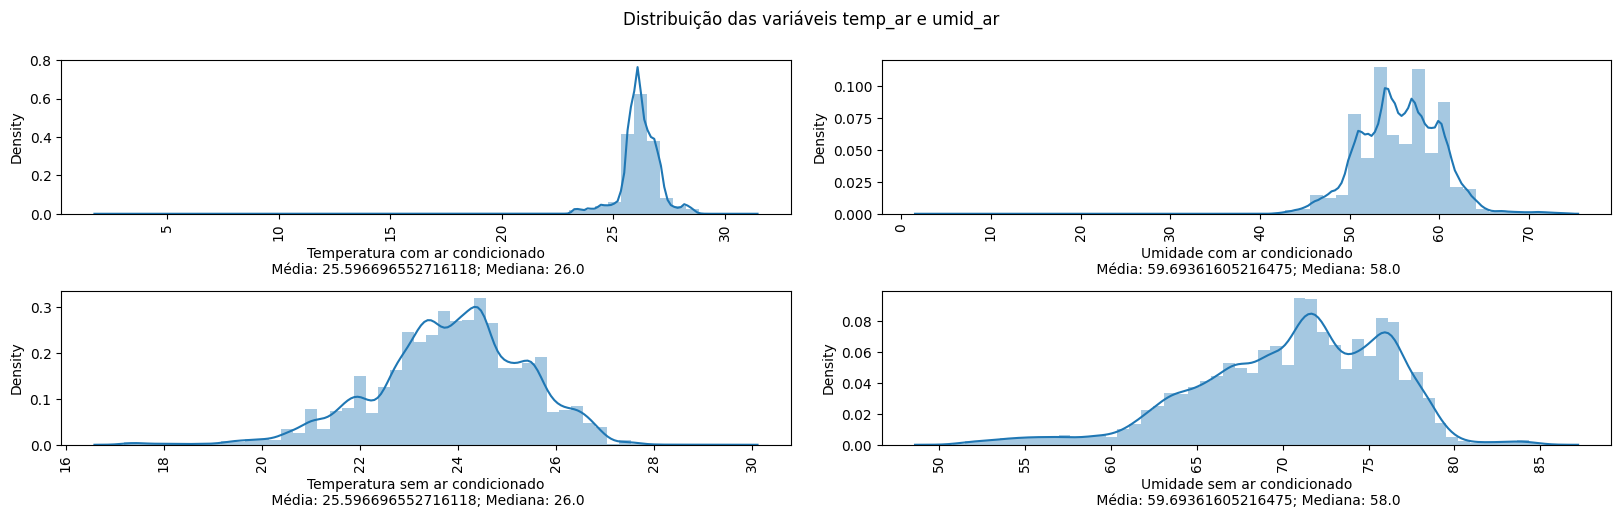

CPU times: user 2.53 s, sys: 344 ms, total: 2.88 s
Wall time: 2.81 s


In [240]:
%%time
fig, axes = plt.subplots(2, 2, figsize = (20,5))
fig.subplots_adjust(hspace=0.5, wspace=0.125)
fig.suptitle('Distribuição das variáveis temp_ar e umid_ar')

#Temperatura - distplot
sns.distplot(ax=axes[0,0],x=df_comAr['temp_ar'])
axes[0,0].tick_params(axis='x', rotation=90)
axes[0,0].set(xlabel='Temperatura com ar condicionado\n Média: ' + str(df_dados_api['temp_ar'].mean()) + '; Mediana: ' + str(df_dados_api['temp_ar'].median()))

#Umidade - distplot
sns.distplot(ax=axes[0,1],x=df_comAr['umid_ar'])
axes[0,1].tick_params(axis='x', rotation=90)
axes[0,1].set(xlabel='Umidade com ar condicionado\n Média: ' + str(df_dados_api['umid_ar'].mean()) + '; Mediana: ' + str(df_dados_api['umid_ar'].median()))

#Temperatura - distplot
sns.distplot(ax=axes[1,0],x=df_semAr['temp_ar'])
axes[1,0].tick_params(axis='x', rotation=90)
axes[1,0].set(xlabel='Temperatura sem ar condicionado\n Média: ' + str(df_dados_api['temp_ar'].mean()) + '; Mediana: ' + str(df_dados_api['temp_ar'].median()))

#Umidade - distplot
sns.distplot(ax=axes[1,1],x=df_semAr['umid_ar'])
axes[1,1].tick_params(axis='x', rotation=90)
axes[1,1].set(xlabel='Umidade sem ar condicionado\n Média: ' + str(df_dados_api['umid_ar'].mean()) + '; Mediana: ' + str(df_dados_api['umid_ar'].median()))

plt.show();

Testando se as distruições são normais

In [241]:
%%time
stat_temp_comar,p_temp_comarar = stats.shapiro(df_comAr['temp_ar'].to_numpy())
stat_umid_comarar,p_umid_comarar = stats.shapiro(df_comAr['umid_ar'].to_numpy())

stat_temp_semar,p_temp_semar = stats.shapiro(df_semAr['temp_ar'].to_numpy())
stat_umid_semar,p_umid_semar = stats.shapiro(df_semAr['umid_ar'].to_numpy())

CPU times: user 13.7 ms, sys: 0 ns, total: 13.7 ms
Wall time: 22 ms


In [242]:
print(f'p-value temp_ar com ar condicionado: {p_temp_comarar:.5f}')
print(f'p-value umid_ar com ar condicionado: {p_umid_comarar:.5f}')
print(f'p-value temp_ar sem ar condicionado: {p_temp_semar:.5f}')
print(f'p-value umid_ar sem ar condicionado: {p_umid_semar:.5f}')

p-value temp_ar com ar condicionado: 0.00000
p-value umid_ar com ar condicionado: 0.00000
p-value temp_ar sem ar condicionado: 0.00000
p-value umid_ar sem ar condicionado: 0.00000


Com os p_values < 0.5, logo curvas não normais.

# Tratando data

Copiando dataframes para uma nova variável

In [243]:
dados_projeto_comar = df_comAr.copy()
dados_projeto_semar = df_semAr.copy()

Removendo virgula de time.data e concatenando com time.hora para gerar data no formato datetime

In [244]:
def converte_data_portugues_para_ingles(df):
  return datetime.strptime(df['time.data'], "%d/%m/%Y").strftime("%Y-%m-%d");

In [245]:
dados_projeto_comar['time.data'] = dados_projeto_comar['time.data'].str.replace(',','')
dados_projeto_comar['time.data'] = dados_projeto_comar.apply(lambda x: converte_data_portugues_para_ingles(x), axis=1)
dados_projeto_comar['data'] = dados_projeto_comar['time.data'] + ' ' + dados_projeto_comar['time.hora']
dados_projeto_comar['data'] = dados_projeto_comar['data'].astype('datetime64[ns]')

dados_projeto_semar['time.data'] = dados_projeto_semar['time.data'].str.replace(',','')
dados_projeto_semar['time.data'] = dados_projeto_semar.apply(lambda x: converte_data_portugues_para_ingles(x), axis=1)
dados_projeto_semar['data'] = dados_projeto_semar['time.data'] + ' ' + dados_projeto_semar['time.hora']
dados_projeto_semar['data'] = dados_projeto_semar['data'].astype('datetime64[ns]')

In [246]:
dados_projeto_semar.tail()

,temp_ar,umid_ar,local,time.data,time.hora,data
83418,24.20,64.20,semAr,2023-05-06,11:58:57,2023-05-06 11:58:57
83420,24.20,64.10,semAr,2023-05-06,12:03:59,2023-05-06 12:03:59
83422,24.20,64.00,semAr,2023-05-06,12:09:02,2023-05-06 12:09:02
83424,24.20,63.60,semAr,2023-05-06,12:14:03,2023-05-06 12:14:03
83426,24.30,63.50,semAr,2023-05-06,12:19:05,2023-05-06 12:19:05


Verificando nulos novamente

In [247]:
dados_projeto_semar.isnull().sum()

temp_ar      0
umid_ar      0
local        0
time.data    0
time.hora    0
data         0
dtype: int64

In [248]:
dados_projeto_comar.isnull().sum()

temp_ar      0
umid_ar      0
local        0
time.data    0
time.hora    0
data         0
dtype: int64

Deletando colunas que não vamos usar mais

In [249]:
del dados_projeto_semar['time.data']
del dados_projeto_semar['time.hora']
del dados_projeto_semar['local']

del dados_projeto_comar['time.data']
del dados_projeto_comar['time.hora']
del dados_projeto_comar['local']

# Filtro por período a partir do dia 04/03/2023

In [250]:
filtro = (dados_projeto_comar.data >= '2023-03-04 00:00:00') & (dados_projeto_comar.data < '2023-04-29 00:00:00')
serie_comar = dados_projeto_comar.loc[filtro]
serie_comar.describe()

,temp_ar,umid_ar
count,58219.00,58219.00
mean,26.25,55.64
std,0.78,4.39
min,21.90,42.00
25%,25.90,53.00
50%,26.20,56.00
75%,26.70,59.00
max,29.00,74.00


In [251]:
filtro2 = (dados_projeto_semar.data >= '2023-03-04 00:00:00') & (dados_projeto_semar.data <= '2023-04-26 00:00:00')
serie_semar = dados_projeto_semar.loc[filtro2]
serie_semar.describe()

,temp_ar,umid_ar
count,19558.00,19558.00
mean,23.97,71.11
std,1.50,5.07
min,17.20,50.80
25%,23.10,67.80
50%,24.00,71.60
75%,25.00,75.10
max,29.50,85.00


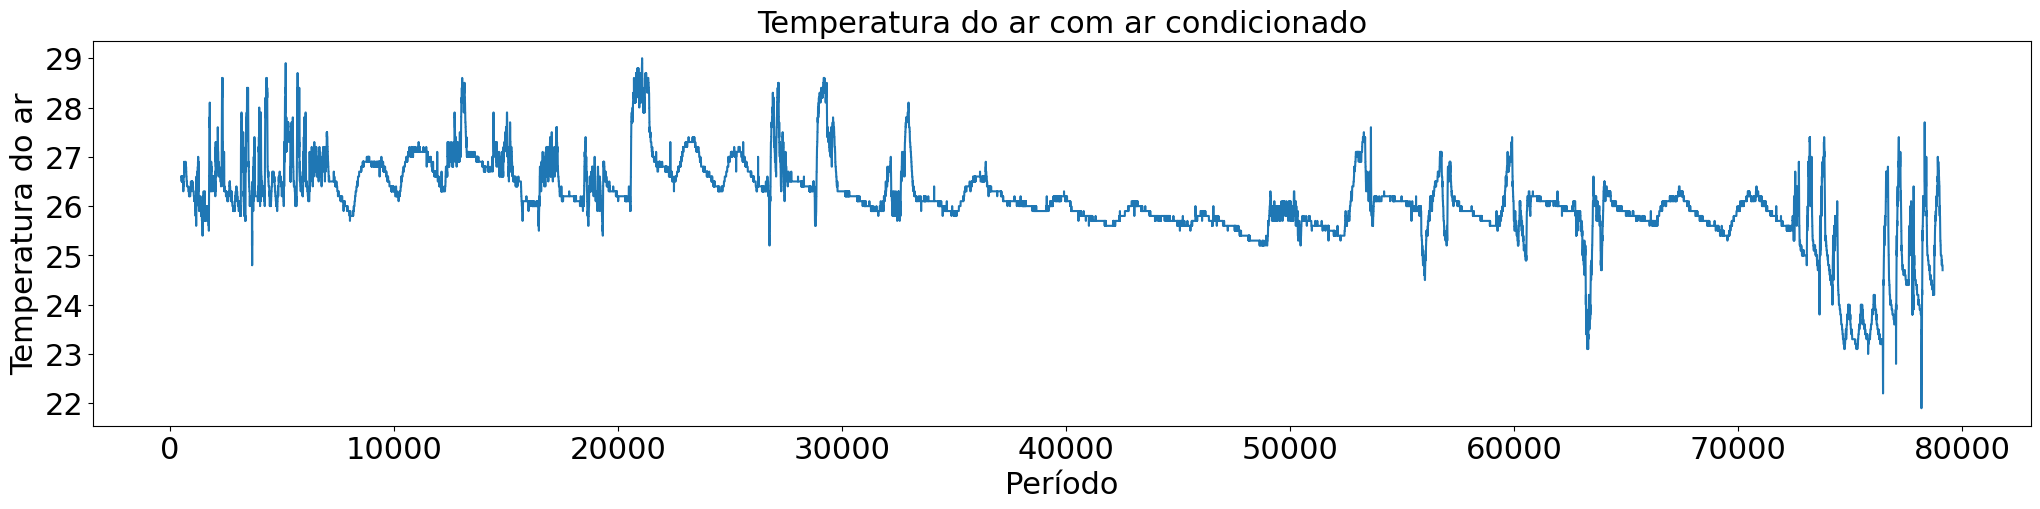

CPU times: user 537 ms, sys: 111 ms, total: 648 ms
Wall time: 528 ms


In [252]:
%%time
plt.figure(figsize=(25,5))
serie_comar.temp_ar.plot()
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel('Período',size=22)
plt.ylabel('Temperatura do ar',size=22)
plt.title('Temperatura do ar com ar condicionado',size=22)

plt.savefig('data_temp_ar_conjunto_tratado_original.png', facecolor='white', transparent=False)  
plt.show() 
plt.close()

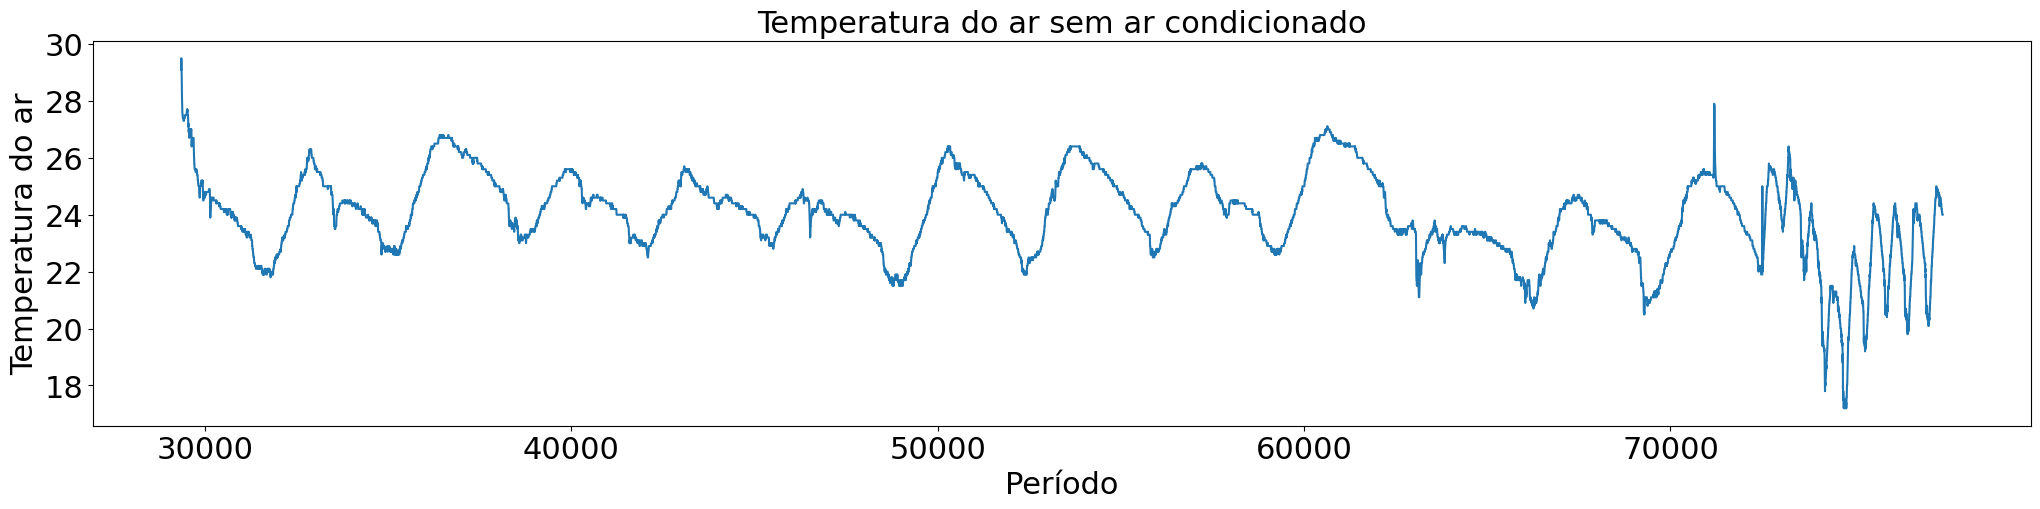

CPU times: user 467 ms, sys: 111 ms, total: 578 ms
Wall time: 474 ms


In [253]:
%%time
plt.figure(figsize=(25,5))
serie_semar.temp_ar.plot()
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel('Período',size=22)
plt.ylabel('Temperatura do ar',size=22)
plt.title('Temperatura do ar sem ar condicionado',size=22)

plt.savefig('data_temp_ar_conjunto_tratado_original_sem_ar.png', facecolor='white', transparent=False)  
plt.show() 
plt.close()

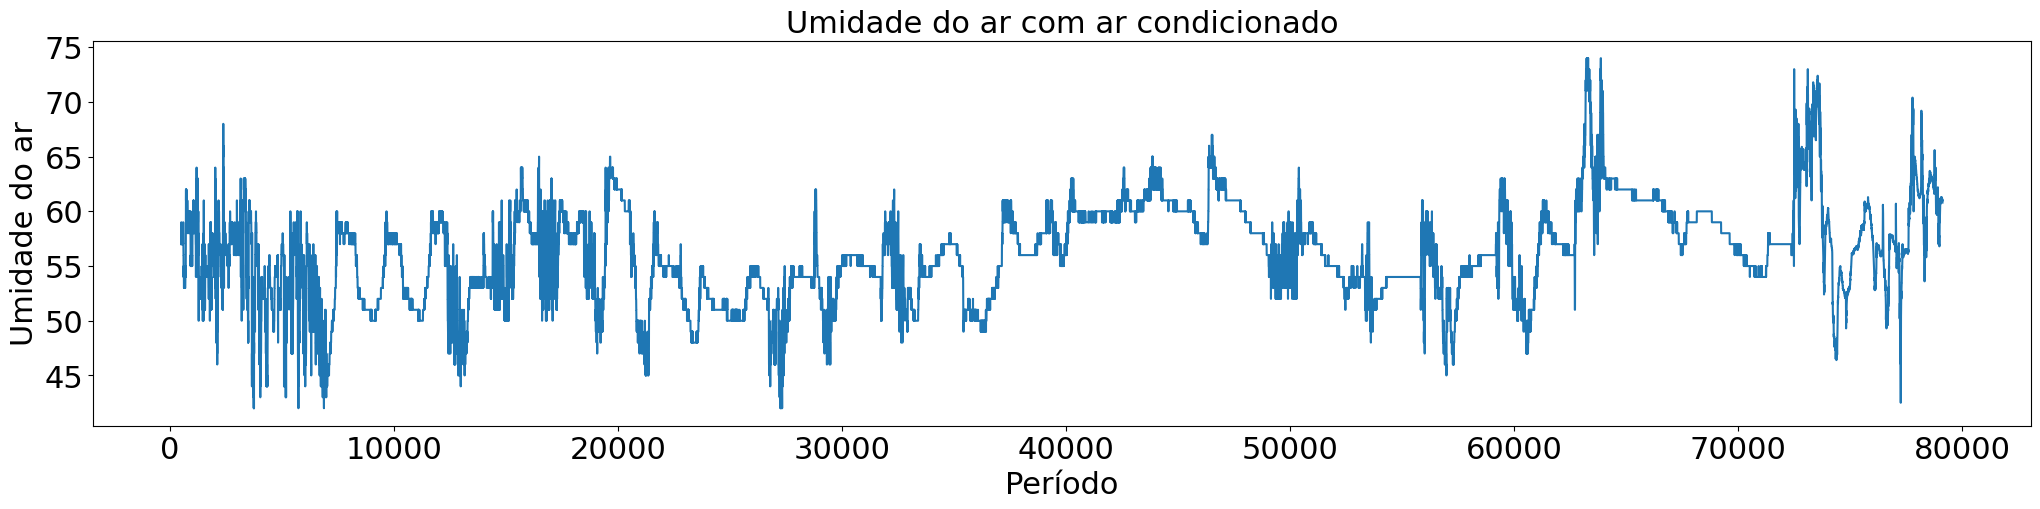

CPU times: user 563 ms, sys: 111 ms, total: 674 ms
Wall time: 578 ms


In [254]:
%%time
plt.figure(figsize=(25,5))
serie_comar.umid_ar.plot()
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel('Período',size=22)
plt.ylabel('Umidade do ar',size=22)
plt.title('Umidade do ar com ar condicionado',size=22)

plt.savefig('data_umidade_ar_conjunto_tratado_original.png', facecolor='white', transparent=False)  
plt.show() 
plt.close()

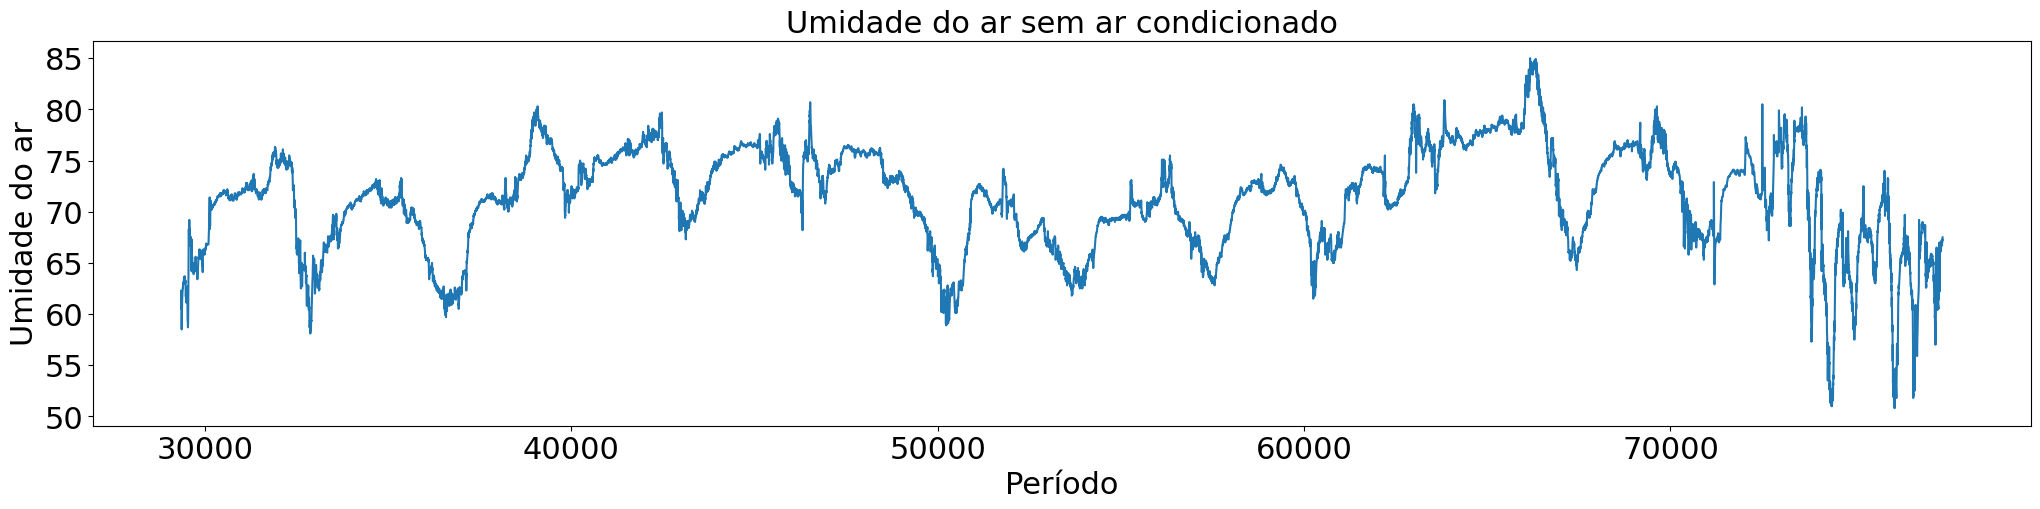

CPU times: user 505 ms, sys: 108 ms, total: 613 ms
Wall time: 521 ms


In [255]:
%%time
plt.figure(figsize=(25,5))
serie_semar.umid_ar.plot()
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel('Período',size=22)
plt.ylabel('Umidade do ar',size=22)
plt.title('Umidade do ar sem ar condicionado',size=22)

plt.savefig('data_umidade_ar_conjunto_tratado_original_sem_ar.png', facecolor='white', transparent=False)  
plt.show() 
plt.close()

# Agrupando dados a cada t minuto(s) utilizando a média

Vamos tentar reduzir o ruído.

Definindo os minutos

In [256]:
minutos = 60

Setando a data como index

In [257]:
serie_comar.set_index('data', inplace=True)
serie_semar.set_index('data', inplace=True)

In [258]:
serie_comar.head(2)

,temp_ar,umid_ar
data,,
2023-03-04 00:04:12,26.60,57.00
2023-03-04 00:09:14,26.60,58.00


Agrupando os valores de data para cada t minuto(s) pela média

In [259]:
%%time
dados_agrupados_minutos_comar = serie_comar.resample(str(minutos) + 'T').mean()
dados_agrupados_minutos_comar.head(2)

CPU times: user 6.66 ms, sys: 0 ns, total: 6.66 ms
Wall time: 8.69 ms


,temp_ar,umid_ar
data,,
2023-03-04 00:00:00,26.60,57.58
2023-03-04 01:00:00,26.59,57.82


In [260]:
%%time
dados_agrupados_minutos_semar = serie_semar.resample(str(minutos) + 'T').mean()
dados_agrupados_minutos_semar.head(2)

CPU times: user 3.83 ms, sys: 0 ns, total: 3.83 ms
Wall time: 4.23 ms


,temp_ar,umid_ar
data,,
2023-04-04 15:00:00,27.68,62.30
2023-04-04 16:00:00,27.14,64.92


Tamanho do conjunto gerado

In [261]:
dados_agrupados_minutos_comar.shape

(1344, 2)

In [262]:
dados_agrupados_minutos_semar.shape

(513, 2)

Verificando nulos

In [263]:
dados_agrupados_minutos_comar.isnull().sum()

temp_ar    5
umid_ar    5
dtype: int64

In [264]:
dados_agrupados_minutos_semar.isnull().sum()

temp_ar    0
umid_ar    0
dtype: int64

Preenchendo nulos com os valores anteriores

In [265]:
dados_agrupados_minutos_comar.fillna(method="ffill", inplace = True)

Verificando novamente os nulos

In [266]:
dados_agrupados_minutos_comar.isnull().sum()

temp_ar    0
umid_ar    0
dtype: int64

# Gráficos

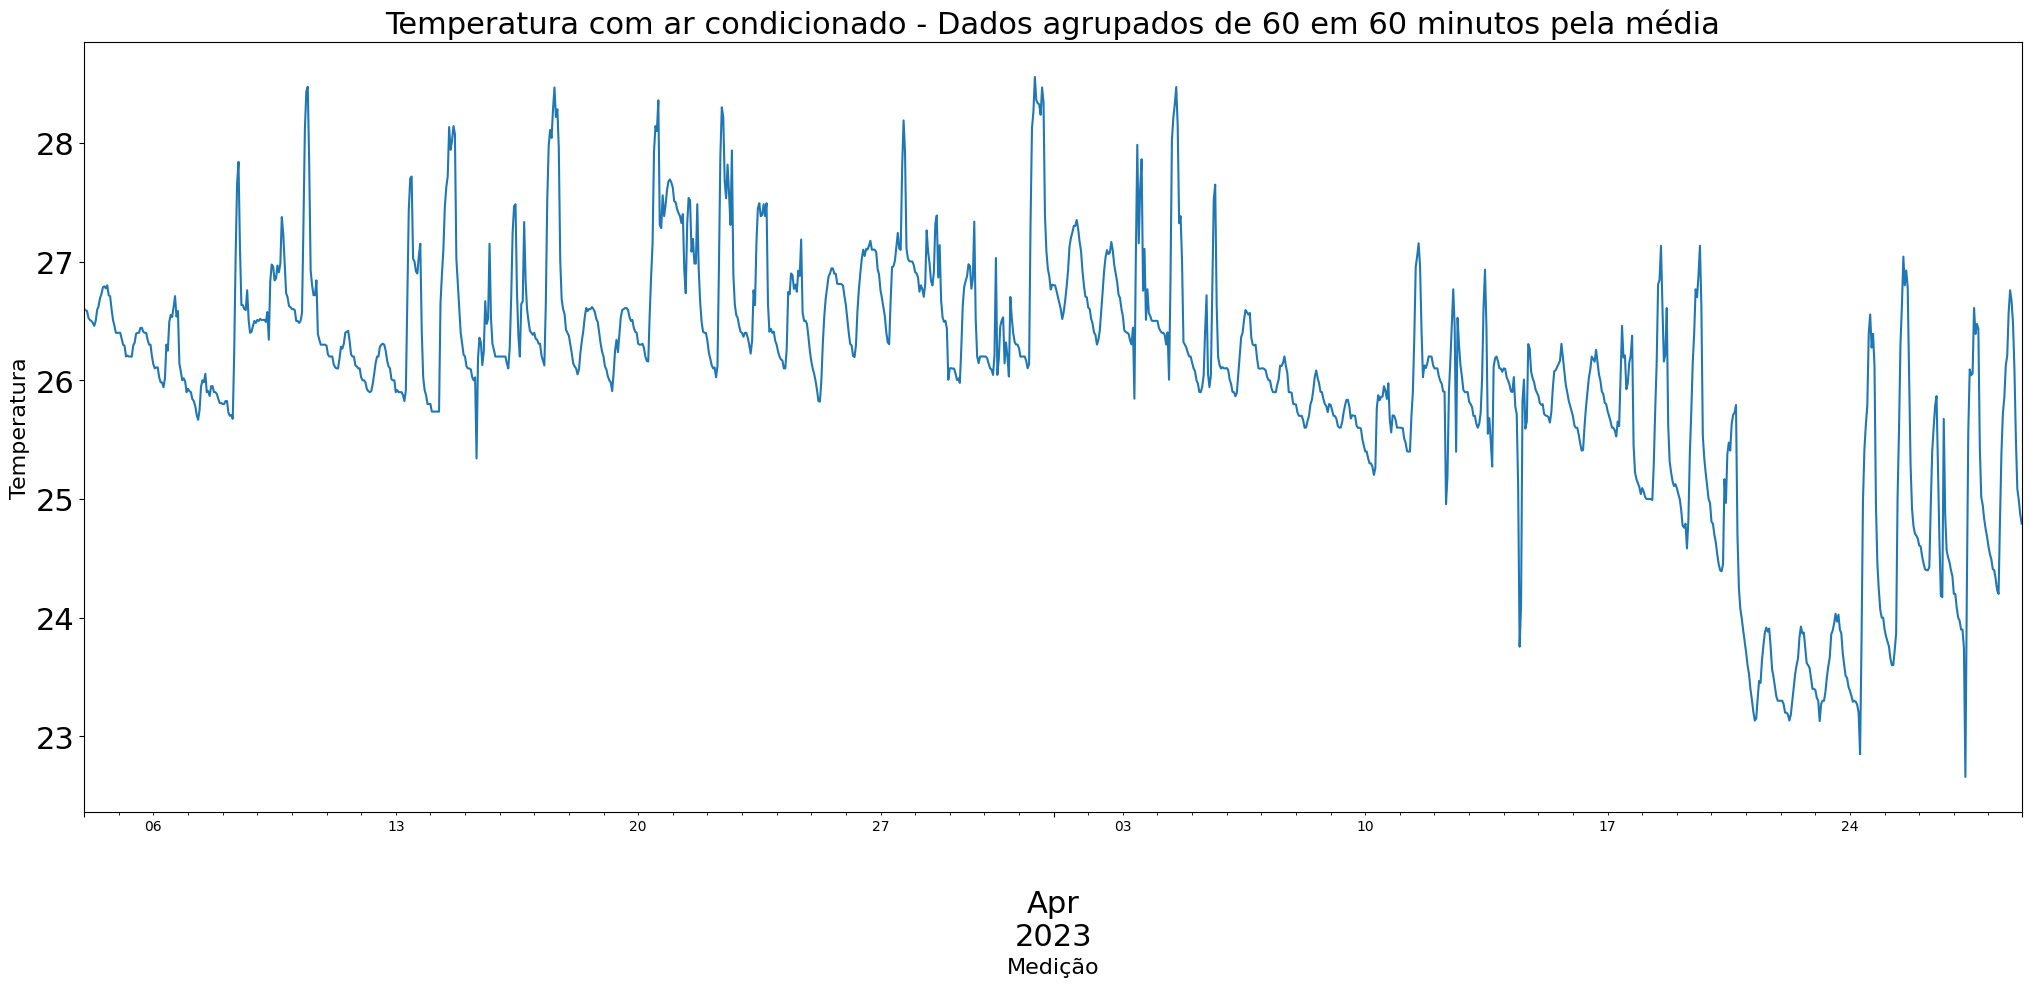

CPU times: user 948 ms, sys: 129 ms, total: 1.08 s
Wall time: 972 ms


In [267]:
%%time
plt.figure(figsize=(25,10))
dados_agrupados_minutos_comar['temp_ar'].plot()
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel('Medição',size=16)
plt.ylabel('Temperatura',size=16)
plt.title(f'Temperatura com ar condicionado - Dados agrupados de {minutos} em {minutos} minutos pela média',size=22)

plt.savefig(f'data_temperatura_ar_conjunto_dados_agrupados_{minutos}_minutos.png', facecolor='white', transparent=False)  
plt.show() 
plt.close()

plt.show()

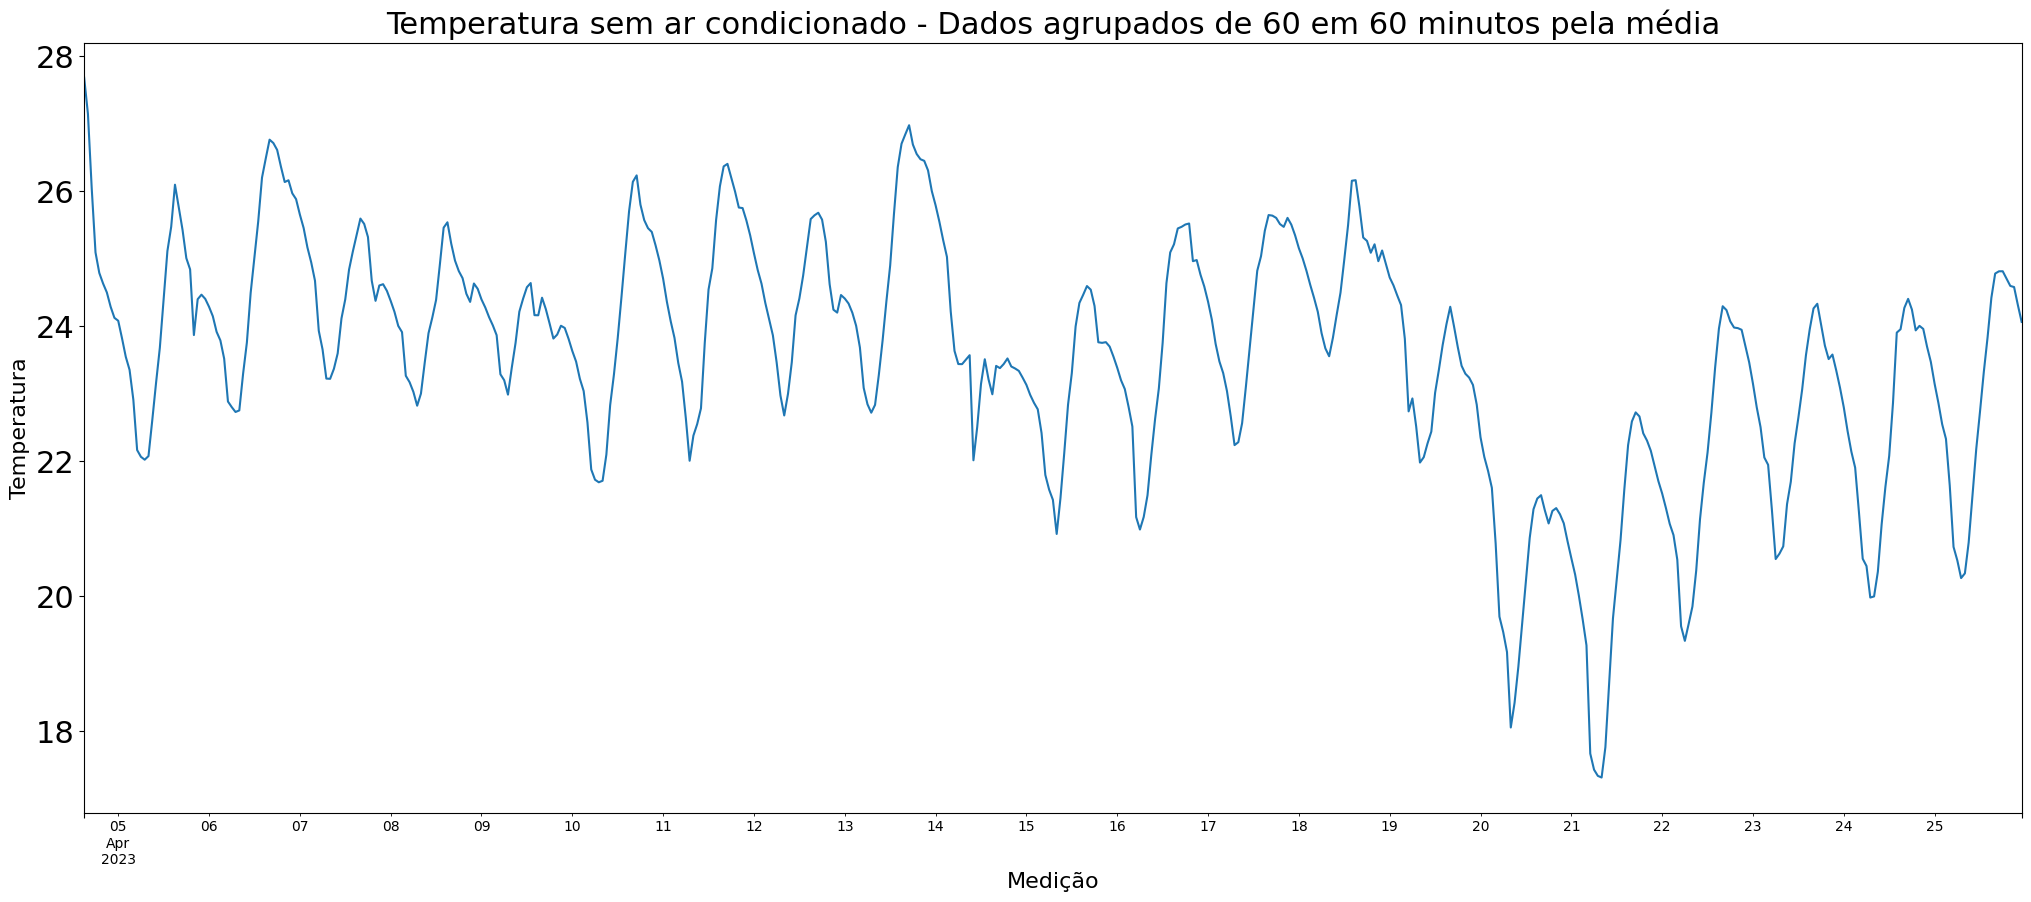

CPU times: user 736 ms, sys: 124 ms, total: 861 ms
Wall time: 745 ms


In [268]:
%%time
plt.figure(figsize=(25,10))
dados_agrupados_minutos_semar['temp_ar'].plot()
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel('Medição',size=16)
plt.ylabel('Temperatura',size=16)
plt.title(f'Temperatura sem ar condicionado - Dados agrupados de {minutos} em {minutos} minutos pela média',size=22)

plt.savefig(f'data_temperatura_ar_conjunto_dados_agrupados_{minutos}_minutos_sem_ar.png', facecolor='white', transparent=False)  
plt.show() 
plt.close()

plt.show()

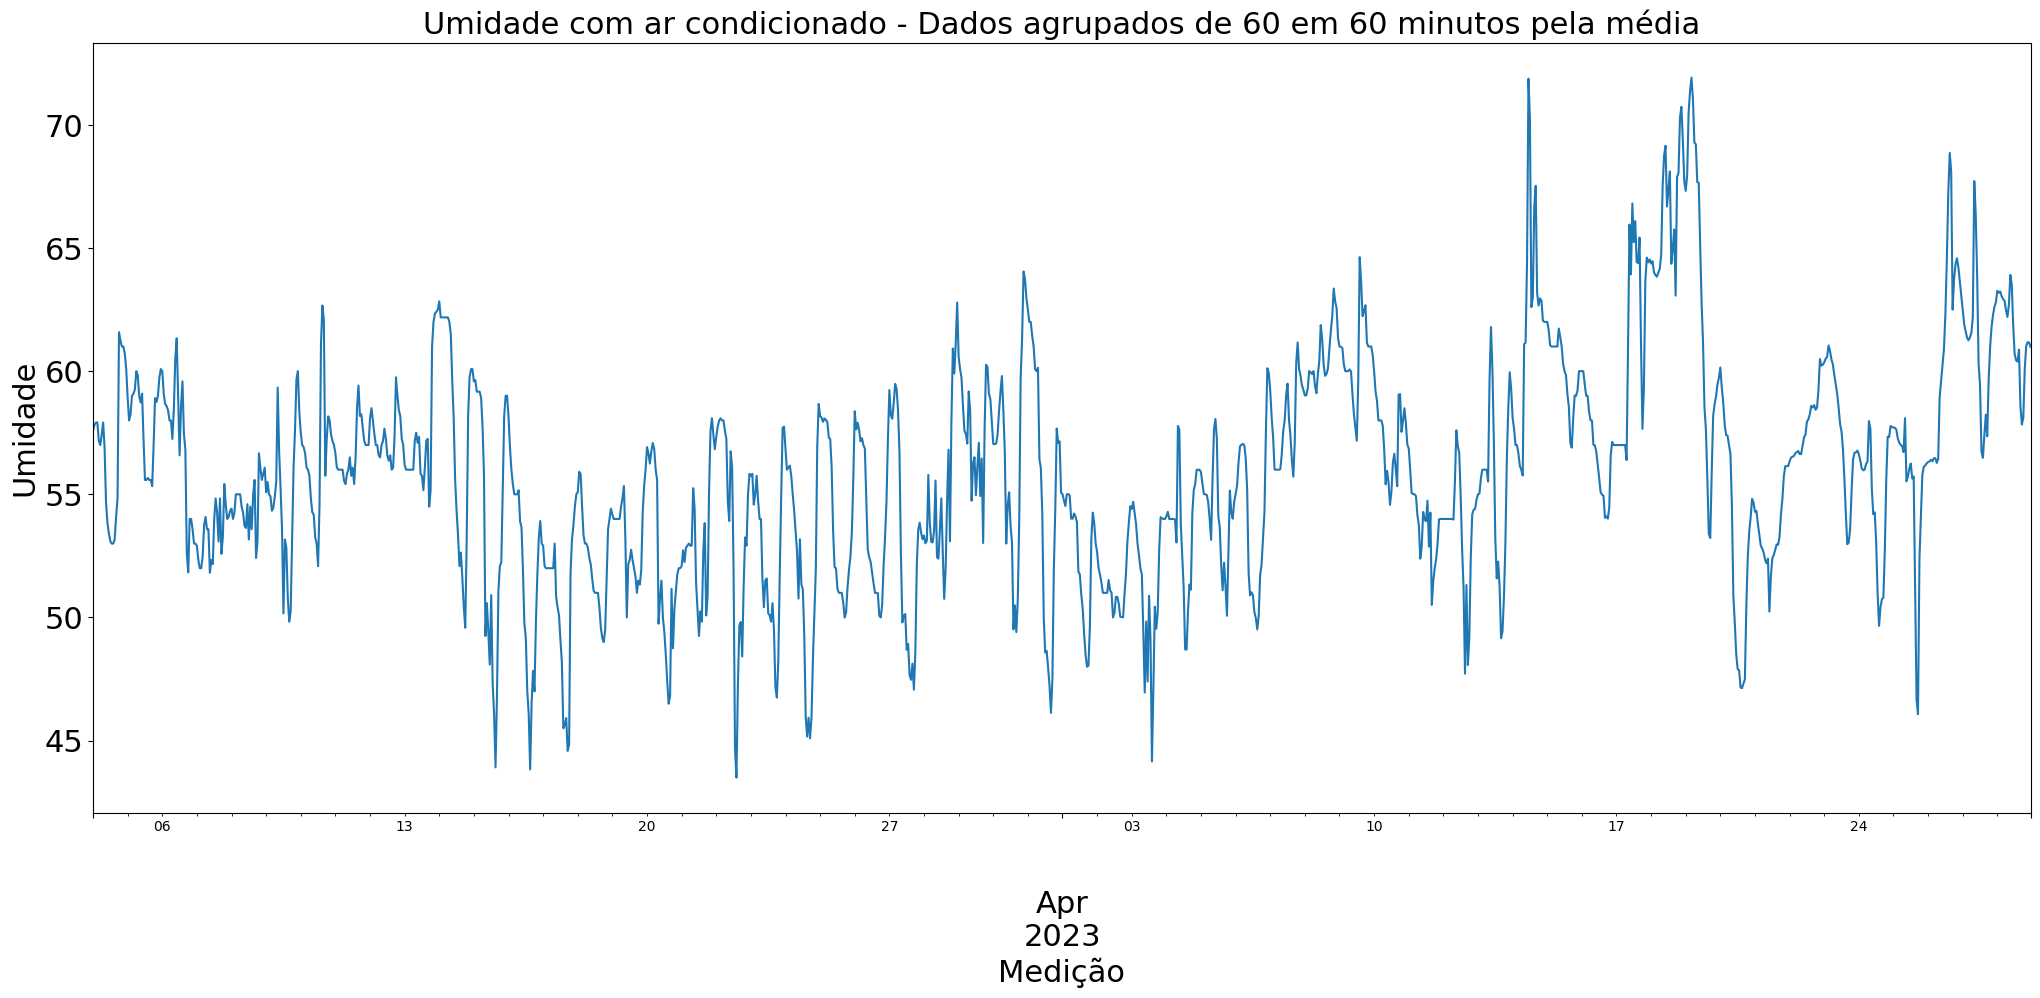

CPU times: user 972 ms, sys: 126 ms, total: 1.1 s
Wall time: 993 ms


In [269]:
%%time
plt.figure(figsize=(25,10))
dados_agrupados_minutos_comar['umid_ar'].plot()
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel('Medição',size=22)
plt.ylabel('Umidade',size=22)
plt.title(f'Umidade com ar condicionado - Dados agrupados de {minutos} em {minutos} minutos pela média',size=22)

plt.savefig(f'data_umidade_ar_conjunto_dados_agrupados_{minutos}_minutos.png', facecolor='white', transparent=False)  
plt.show() 
plt.close()

plt.show()

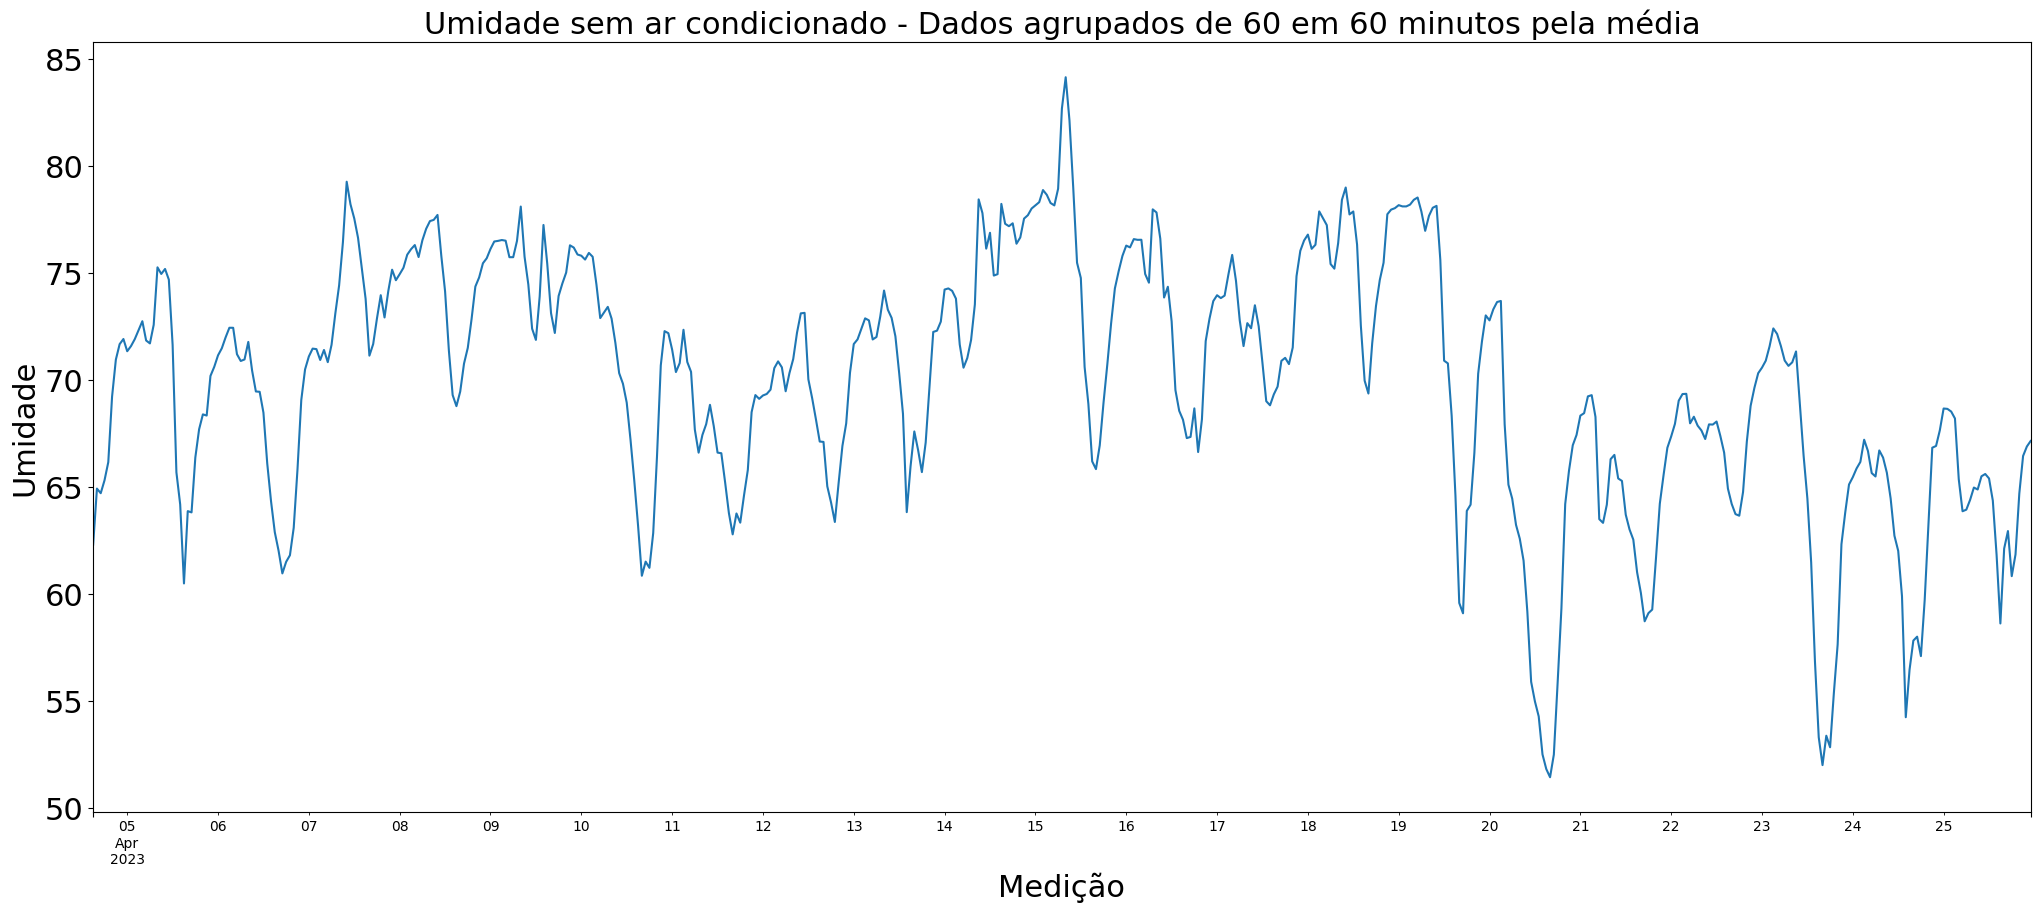

CPU times: user 792 ms, sys: 114 ms, total: 907 ms
Wall time: 806 ms


In [270]:
%%time
plt.figure(figsize=(25,10))
dados_agrupados_minutos_semar['umid_ar'].plot()
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel('Medição',size=22)
plt.ylabel('Umidade',size=22)
plt.title(f'Umidade sem ar condicionado - Dados agrupados de {minutos} em {minutos} minutos pela média',size=22)

plt.savefig(f'data_umidade_ar_conjunto_dados_agrupados_{minutos}_minutos_sem_ar.png', facecolor='white', transparent=False)  
plt.show() 
plt.close()

plt.show()

# Suavização com média móvel e rolling

In [271]:
dados_agrupados_minutos_comar_cp = dados_agrupados_minutos_comar.copy()
dados_agrupados_minutos_semar_cp = dados_agrupados_minutos_semar.copy()

In [272]:
''' dados_agrupados_minutos_comar = dados_agrupados_minutos_comar_cp
dados_agrupados_minutos_semar = dados_agrupados_minutos_semar_cp '''

' dados_agrupados_minutos_comar = dados_agrupados_minutos_comar_cp\ndados_agrupados_minutos_semar = dados_agrupados_minutos_semar_cp '

In [273]:
dados_agrupados_minutos_comar['media_24_horas_temp_ar'] = dados_agrupados_minutos_comar.temp_ar.rolling(48).mean()
dados_agrupados_minutos_comar['media_24_horas_umid_ar'] = dados_agrupados_minutos_comar.umid_ar.rolling(48).mean()

dados_agrupados_minutos_semar['media_24_horas_temp_ar'] = dados_agrupados_minutos_semar.temp_ar.rolling(48).mean()
dados_agrupados_minutos_semar['media_24_horas_umid_ar'] = dados_agrupados_minutos_semar.umid_ar.rolling(48).mean()

In [274]:
dados_agrupados_minutos_comar.head(24)

,temp_ar,umid_ar,media_24_horas_temp_ar,media_24_horas_umid_ar
data,,,,
2023-03-04 00:00:00,26.60,57.58,NaN,NaN
2023-03-04 01:00:00,26.59,57.82,NaN,NaN
2023-03-04 02:00:00,26.58,57.92,NaN,NaN
2023-03-04 03:00:00,26.53,57.92,NaN,NaN
2023-03-04 04:00:00,26.51,57.17,NaN,NaN
2023-03-04 05:00:00,26.50,57.00,NaN,NaN
2023-03-04 06:00:00,26.48,57.42,NaN,NaN
2023-03-04 07:00:00,26.46,57.92,NaN,NaN
2023-03-04 08:00:00,26.50,56.92,NaN,NaN


Comparando a média móvel com os dados

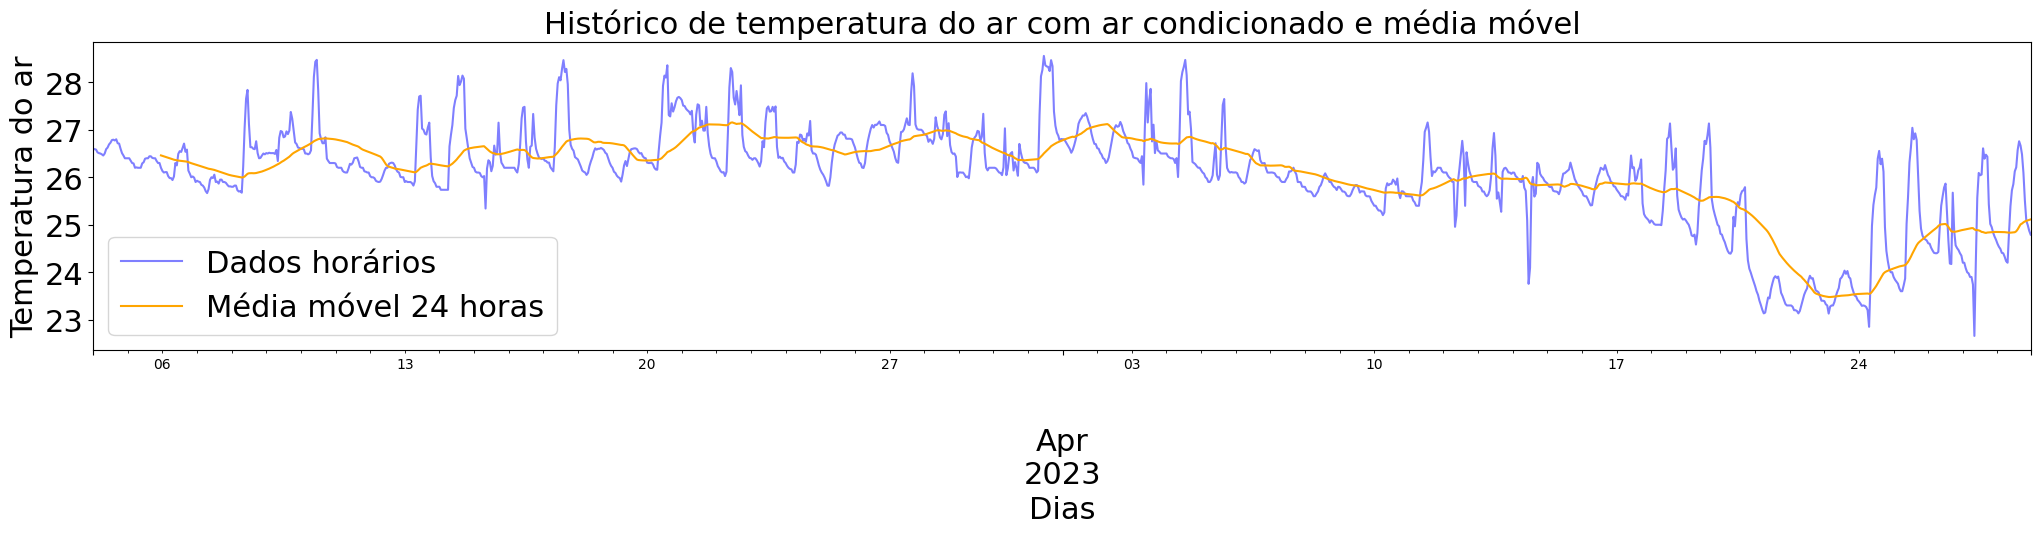

CPU times: user 741 ms, sys: 102 ms, total: 843 ms
Wall time: 738 ms


In [275]:
%%time
plt.figure(figsize=(25,4))
dados_agrupados_minutos_comar.temp_ar.plot(c='blue',alpha=0.5) # Dados reais
dados_agrupados_minutos_comar['media_24_horas_temp_ar'].plot(c='orange') # Dados da média móvel
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel('Dias',size=22)
plt.ylabel('Temperatura do ar',size=22)
plt.title('Histórico de temperatura do ar com ar condicionado e média móvel',size=22)
plt.legend(['Dados horários','Média móvel 24 horas'],fontsize=22)
plt.show()

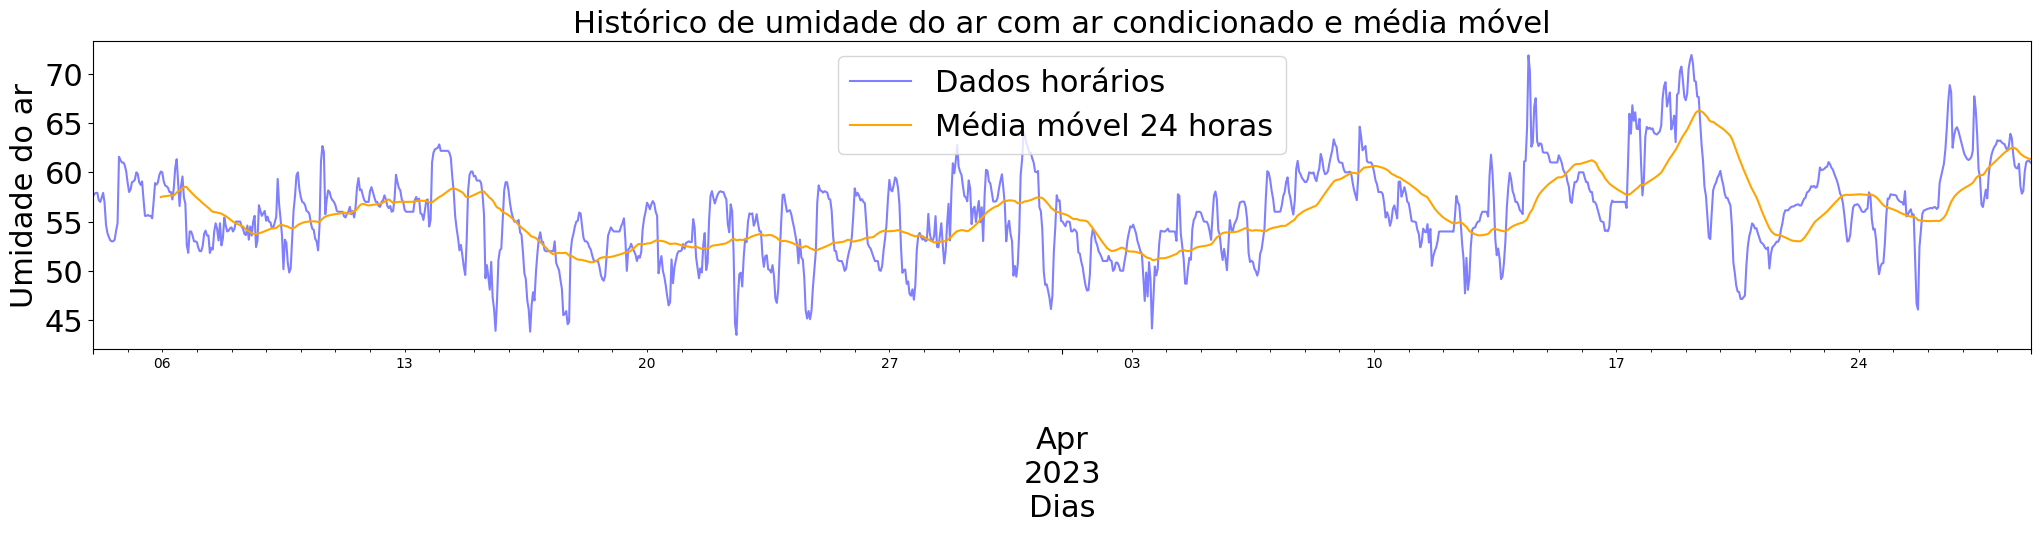

CPU times: user 734 ms, sys: 116 ms, total: 850 ms
Wall time: 733 ms


In [276]:
%%time
plt.figure(figsize=(25,4))
dados_agrupados_minutos_comar.umid_ar.plot(c='blue',alpha=0.5) # Dados reais
dados_agrupados_minutos_comar['media_24_horas_umid_ar'].plot(c='orange') # Dados da média móvel
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel('Dias',size=22)
plt.ylabel('Umidade do ar',size=22)
plt.title('Histórico de umidade do ar com ar condicionado e média móvel',size=22)
plt.legend(['Dados horários','Média móvel 24 horas'],fontsize=22)
plt.show()

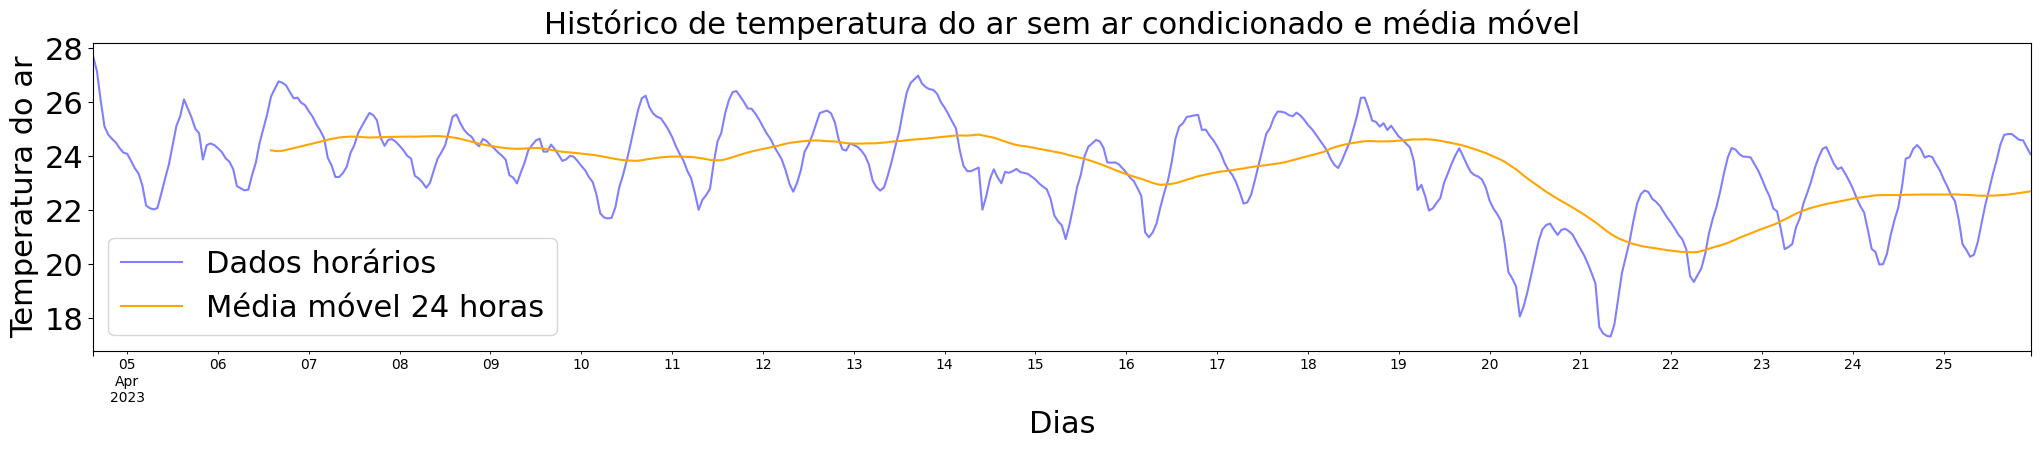

CPU times: user 508 ms, sys: 83.2 ms, total: 591 ms
Wall time: 524 ms


In [277]:
%%time
plt.figure(figsize=(25,4))
dados_agrupados_minutos_semar.temp_ar.plot(c='blue',alpha=0.5) # Dados reais
dados_agrupados_minutos_semar['media_24_horas_temp_ar'].plot(c='orange') # Dados da média móvel
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel('Dias',size=22)
plt.ylabel('Temperatura do ar',size=22)
plt.title('Histórico de temperatura do ar sem ar condicionado e média móvel',size=22)
plt.legend(['Dados horários','Média móvel 24 horas'],fontsize=22)
plt.show()

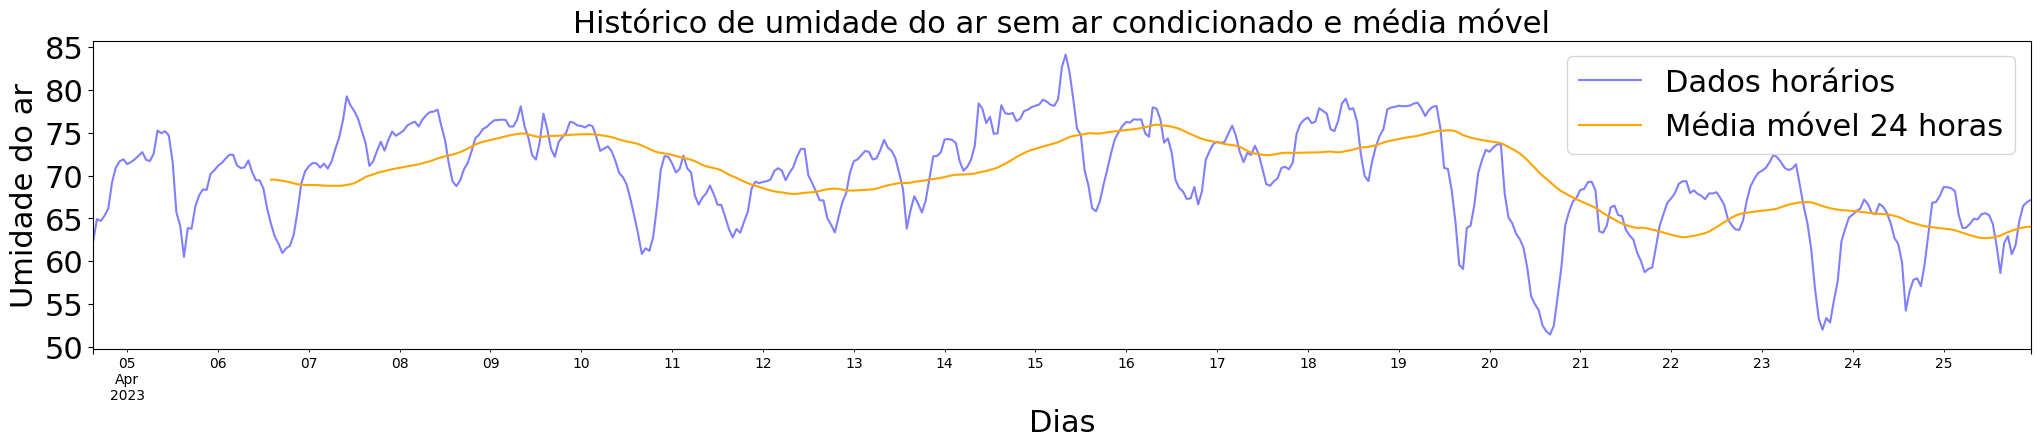

CPU times: user 655 ms, sys: 73.3 ms, total: 728 ms
Wall time: 733 ms


In [278]:
%%time
plt.figure(figsize=(25,4))
dados_agrupados_minutos_semar.umid_ar.plot(c='blue',alpha=0.5) # Dados reais
dados_agrupados_minutos_semar['media_24_horas_umid_ar'].plot(c='orange') # Dados da média móvel
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel('Dias',size=22)
plt.ylabel('Umidade do ar',size=22)
plt.title('Histórico de umidade do ar sem ar condicionado e média móvel',size=22)
plt.legend(['Dados horários','Média móvel 24 horas'],fontsize=22)
plt.show()

# ARIMA


In [279]:
#!pip install pmdarima

In [283]:
%%time
from pmdarima.arima import auto_arima
modelo = auto_arima(dados_agrupados_minutos_comar.temp_ar)

CPU times: user 42.5 s, sys: 35.9 s, total: 1min 18s
Wall time: 53.5 s


In [284]:
modelo.predict_in_sample()

data
2023-03-04 00:00:00    0.00
2023-03-04 01:00:00   26.60
2023-03-04 02:00:00   26.59
2023-03-04 03:00:00   26.58
2023-03-04 04:00:00   26.51
                       ... 
2023-04-28 19:00:00   25.86
2023-04-28 20:00:00   25.26
2023-04-28 21:00:00   24.90
2023-04-28 22:00:00   24.88
2023-04-28 23:00:00   24.77
Freq: 60T, Name: predicted_mean, Length: 1344, dtype: float64

In [289]:
modelo.predict(5)

2023-04-29 00:00:00   24.75
2023-04-29 01:00:00   24.74
2023-04-29 02:00:00   24.76
2023-04-29 03:00:00   24.82
2023-04-29 04:00:00   24.90
Freq: 60T, dtype: float64

In [286]:
%%time
modelo_semar = auto_arima(dados_agrupados_minutos_semar.temp_ar)

CPU times: user 3.97 s, sys: 3.28 s, total: 7.25 s
Wall time: 4.62 s


In [287]:
modelo_semar.predict_in_sample()

data
2023-04-04 15:00:00    0.00
2023-04-04 16:00:00   27.68
2023-04-04 17:00:00   26.78
2023-04-04 18:00:00   25.32
2023-04-04 19:00:00   24.43
                       ... 
2023-04-25 19:00:00   24.81
2023-04-25 20:00:00   24.63
2023-04-25 21:00:00   24.52
2023-04-25 22:00:00   24.56
2023-04-25 23:00:00   24.14
Freq: 60T, Name: predicted_mean, Length: 513, dtype: float64

In [290]:
modelo_semar.predict(5)

2023-04-26 00:00:00   23.89
2023-04-26 01:00:00   23.77
2023-04-26 02:00:00   23.68
2023-04-26 03:00:00   23.62
2023-04-26 04:00:00   23.57
Freq: 60T, dtype: float64